<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** 
- Rodrigo Martínez Gallardo Bertoldi
- Pablo Alejandro Rivera Sánchez

**Fecha:** 4 de mayo del 2021.

**Expediente** : 
- 
- 722268
- 721005
    
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 10: Clase 23.

[Liga al repositorio](https://github.com/rodrigomart1nez/ProyectoConjunto_RMartinez_PRivera)

### Proyecto Conjunto.
> Instrucciones: Cada estudiante debe proponer una solución óptima a los problemas planteados a continuación.

# Tarea

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:

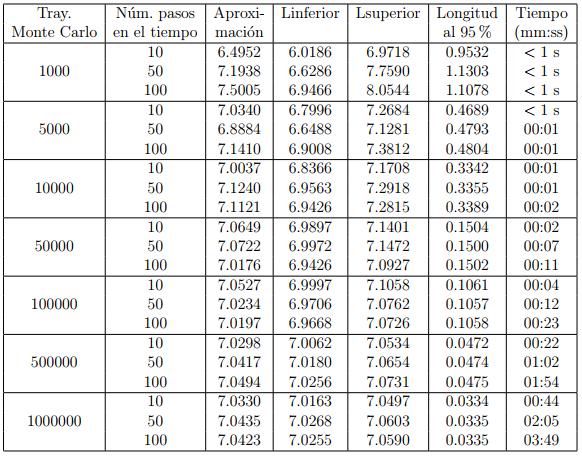

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

### _Solución Rodrigo._

### _Solución Pablo._

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time as time

from timeit import default_timer as timer
from datetime import timedelta
%matplotlib inline

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T, t # Transpuesta para que cada columan sea la trayectoria

def calc_daily_ret(closes):
    '''
    Función que nos regresa los rendimientos diaros de los precios de cierre ajustados.
    '''
    return np.log(closes/closes.shift(1)).iloc[1:] 

# Método de esquemas del trapecio

Iniciamos creando la función que nos calcula la prima de la opción asiática para las trayectorias y pasos especificados con el método de esquemas del trapecio. Esta función se basa en la fórmula que vimos en clase:

$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$

En donde $h = \frac{T}{N}$. Primero generamos precios aleatorios futuros (simulación de precios) y con base en ellos aplicamos la fórmula y calculamos el precio/prima de la opción con este método.

In [3]:
def Trapecios(S0:'Precio subyacente inicial',
             K:'Strike price',
             r:'Tasa libre de riesgo',
             sigma:'Volatilidad',
             T:'Tiempo de cierre del contrato en año',
             NTray:'Número de trayectorias (escenarios)',
             NStep:'Cantidad de pasos a simular'):
    '''
    Función que calcula el valor de una opción call asiática por el 
    método de esquemas del trapecio.
    '''
    # Generamos precios aleatorios con la función de arriba
    St,t = BSprices(r, sigma, S0, NTray, NStep)
    prices = pd.DataFrame(St,index=t)
    
    # Valor de h
    h = T / NStep
    
    # Calculamos la sumatoria de adentro (parte izquierda)
    start = timer()
    #sumat = pd.DataFrame([[(h / (2*T)) * prices.iloc[i,j] * ((2 + (r*h) + sigma*(np.random.randn()))) 
    #                       for j in range(NTray)] for i in range(NStep)])
    # Esto de arriba tardaba mucho, por lo que lo hice trabajando sobre el DataFrame
    sumat = (h / (2*T)) * prices * ((2 + (r*h) + sigma*(np.random.randn(*prices.shape)))) 
    fleft = sumat.cumsum()

    # Calculamos la prima de la opción con base a la fórmula
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(fleft - K, 0).mean(axis=1)}, index=t)
    end = timer()
    #call.plot()
    
    # Niveles de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    
    return call.iloc[-1].Prima, i1, i1[1]-i1[0], str(timedelta(seconds=end-start))

Teniendo la función creada, calculamos el precio de la opción asiática y su respectivo nivel de confianza para varias trayectorias con diferentes pasos, esto con ayuda de un ciclo for anidado hecho con una compresión de listas.

In [4]:
# Trayectorias y pasos sobre los que vamos a simular
Tray = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
Pasos = [10, 50, 100]

In [5]:
calcs = [[Trapecios(100, 100, 0.10, 0.20, 1, Tray[j], Pasos[i]) for i in range(len(Pasos))] for j in range(len(Tray))]
calcs

[[(6.702629860460369,
   (5.387911157766154, 8.017348563154584),
   2.6294374053884306,
   '0:00:00.012379'),
  (7.449974440155949,
   (7.00857642391097, 7.891372456400928),
   0.8827960324899582,
   '0:00:00.006188'),
  (6.851620787154355,
   (6.586172161209929, 7.11706941309878),
   0.5308972518888506,
   '0:00:00.007212')],
 [(6.872801798996719,
   (5.525336581406213, 8.220267016587226),
   2.6949304351810124,
   '0:00:00.012620'),
  (7.009925532525935,
   (6.597231937750177, 7.422619127301694),
   0.8253871895515168,
   '0:00:00.021233'),
  (7.016251716853921,
   (6.7409342434156, 7.2915691902922415),
   0.5506349468766416,
   '0:00:00.036507')],
 [(6.945939994624968,
   (5.583629928791509, 8.308250060458427),
   2.724620131666918,
   '0:00:00.023527'),
  (7.060929244110005,
   (6.643333583394178, 7.478524904825832),
   0.8351913214316546,
   '0:00:00.039647'),
  (6.921334168622215,
   (6.649840601356544, 7.192827735887885),
   0.5429871345313408,
   '0:00:00.071165')],
 [(6.856207

Después de obtener los resultados, los ordenamos en un DataFrame para una mejor visualización como se muestra a continuación.

In [6]:
index = pd.MultiIndex.from_product([Tray, Pasos],
                                  names = ['Tray. Monte Carlo', 'Núm. pasos'])
df = pd.DataFrame(index=index,
                  columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'])

In [7]:
df['Aproximación'] = np.concatenate([[calcs[j][i][0] for i in range(len(Pasos))] for j in range(len(Tray))])
df['Linferior'] = np.concatenate([[calcs[j][i][1][0] for i in range(len(Pasos))] for j in range(len(Tray))])
df['Lsuperior'] = np.concatenate([[calcs[j][i][1][1] for i in range(len(Pasos))] for j in range(len(Tray))])
df['Longitud al 95%'] = np.concatenate([[calcs[j][i][2] for i in range(len(Pasos))] for j in range(len(Tray))])
df['Tiempo'] = np.concatenate([[calcs[j][i][3] for i in range(len(Pasos))] for j in range(len(Tray))])
df

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos                                       
1000              10              6.702630   5.387911   8.017349   
                  50              7.449974   7.008576   7.891372   
                  100             6.851621   6.586172   7.117069   
5000              10              6.872802   5.525337   8.220267   
                  50              7.009926   6.597232   7.422619   
                  100             7.016252   6.740934   7.291569   
10000             10              6.945940   5.583630   8.308250   
                  50              7.060929   6.643334   7.478525   
                  100             6.921334   6.649841   7.192828   
50000             10              6.856208   5.511983   8.200432   
                  50              6.992594   6.579393   7.405795   
                  100             7.049400   6.771757   7.327043   
100000            10              6.894048   5.542012   8.246084   
                  50              7.002017   6.588431   7.415603   
                  100             7.048945   6.771805   7.326085   
500000            10              6.917327   5.560652   8.274002   
                  50              6.998444   6.585401   7.411488   
                  100             7.025696   6.749559   7.301833   
1000000           10              6.899343   5.546222   8.252463   
                  50              7.013899   6.599787   7.428011   
                  100             7.034060   6.757438   7.310682   

                              Longitud al 95%          Tiempo  
Tray. Monte Carlo Núm. pasos                                   
1000              10                 2.629437  0:00:00.012379  
                  50                 0.882796  0:00:00.006188  
                  100                0.530897  0:00:00.007212  
5000              10                 2.694930  0:00:00.012620  
                  50                 0.825387  0:00:00.021233  
                  100                0.550635  0:00:00.036507  
10000             10                 2.724620  0:00:00.023527  
                  50                 0.835191  0:00:00.039647  
                  100                0.542987  0:00:00.071165  
50000             10                 2.688449  0:00:00.106523  
                  50                 0.826402  0:00:00.229257  
                  100                0.555286  0:00:00.391991  
100000            10                 2.704071  0:00:00.216201  
                  50                 0.827172  0:00:00.410500  
                  100                0.554280  0:00:00.731602  
500000            10                 2.713350  0:00:00.968733  
                  50                 0.826087  0:00:02.500052  
                  100                0.552275  0:00:04.395474  
1000000           10                 2.706241  0:00:01.936390  
                  50                 0.828224  0:00:05.094005  
                  100                0.553244  0:00:09.081128

# Método Riemann

Por último, repetimos el proceso anterior pero ahora usando el método de Riemann, es decir, volvemos a calcular el precio de la opción con este otro método. Podemos hacer estos cálculos nuevamente con una función, la cual desarrollamos en clase. 

In [8]:
# Función donde se almacenan todos los resultados
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    start = timer()
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
    call = pd.DataFrame({'Prima': np.exp(-r*T) \
                 *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    
    end = timer()
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call.sem().Prima
    mean_est = call.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
#     return np.array([call.iloc[-1].Prima,i1[0],i1[1]])
#     if flag==True:
# #         calcular intervarlo
#         return call, intervalo
#     else 
    return call.iloc[-1].Prima, i1, i1[1]-i1[0], str(timedelta(seconds=end-start))

Con ayuda de la función obtenemos los siguientes resultados, los cuales se calcularon sobre el mismo número de trayectorias y de pasos que el método anterior. De igual manera, para una mejor visualización, acomodamos los resultados en un DataFrame final. 

In [9]:
calcsR = [[Riemann_approach(100, 0.10, 100, Tray[j], Pasos[i], 0.20, 1) for i in range(len(Pasos))] for j in range(len(Tray))]
calcsR

[[(6.486340832278827,
   (5.204922020663811, 7.767759643893844),
   2.562837623230033,
   '0:00:00.032980'),
  (6.977095017824459,
   (6.459763536619664, 7.494426499029253),
   1.0346629624095893,
   '0:00:00.031043'),
  (7.657456757781513,
   (7.259346623944894, 8.055566891618131),
   0.7962202676732373,
   '0:00:00.025371')],
 [(6.6005274328042525,
   (5.292355797827384, 7.908699067781121),
   2.6163432699537363,
   '0:00:00.109416'),
  (7.015895181054736,
   (6.489836082361559, 7.541954279747913),
   1.0521181973863545,
   '0:00:00.113377'),
  (7.270991079013565,
   (6.894958331541266, 7.647023826485864),
   0.7520654949445973,
   '0:00:00.120620')],
 [(6.279933192861775,
   (5.043631397152032, 7.516234988571519),
   2.472603591419487,
   '0:00:00.216511'),
  (6.868287868351586,
   (6.356568488159823, 7.3800072485433486),
   1.0234387603835255,
   '0:00:00.224496'),
  (6.973046682543036,
   (6.613999027392465, 7.332094337693608),
   0.7180953103011429,
   '0:00:00.235171')],
 [(6.42

In [10]:
index2 = pd.MultiIndex.from_product([Tray, Pasos],
                                  names = ['Tray. Monte Carlo', 'Núm. pasos'])
df2 = pd.DataFrame(index=index2,
                  columns=['Aproximación', 'Linferior', 'Lsuperior', 'Longitud al 95%', 'Tiempo'])

In [11]:
df2['Aproximación'] = np.concatenate([[calcsR[j][i][0] for i in range(len(Pasos))] for j in range(len(Tray))])
df2['Linferior'] = np.concatenate([[calcsR[j][i][1][0] for i in range(len(Pasos))] for j in range(len(Tray))])
df2['Lsuperior'] = np.concatenate([[calcsR[j][i][1][1] for i in range(len(Pasos))] for j in range(len(Tray))])
df2['Longitud al 95%'] = np.concatenate([[calcsR[j][i][2] for i in range(len(Pasos))] for j in range(len(Tray))])
df2['Tiempo'] = np.concatenate([[calcsR[j][i][3] for i in range(len(Pasos))] for j in range(len(Tray))])
df2

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos                                       
1000              10              6.486341   5.204922   7.767760   
                  50              6.977095   6.459764   7.494426   
                  100             7.657457   7.259347   8.055567   
5000              10              6.600527   5.292356   7.908699   
                  50              7.015895   6.489836   7.541954   
                  100             7.270991   6.894958   7.647024   
10000             10              6.279933   5.043631   7.516235   
                  50              6.868288   6.356568   7.380007   
                  100             6.973047   6.613999   7.332094   
50000             10              6.423287   5.149103   7.697472   
                  50              6.903528   6.389428   7.417628   
                  100             7.018786   6.657368   7.380204   
100000            10              6.398564   5.131042   7.666085   
                  50              6.949367   6.430699   7.468036   
                  100             6.950586   6.592189   7.308983   
500000            10              6.418408   5.146041   7.690774   
                  50              6.913124   6.397520   7.428728   
                  100             6.972120   6.612807   7.331433   
1000000           10              6.421628   5.148731   7.694526   
                  50              6.909678   6.393755   7.425601   
                  100             6.972205   6.612971   7.331440   

                              Longitud al 95%          Tiempo  
Tray. Monte Carlo Núm. pasos                                   
1000              10                 2.562838  0:00:00.032980  
                  50                 1.034663  0:00:00.031043  
                  100                0.796220  0:00:00.025371  
5000              10                 2.616343  0:00:00.109416  
                  50                 1.052118  0:00:00.113377  
                  100                0.752065  0:00:00.120620  
10000             10                 2.472604  0:00:00.216511  
                  50                 1.023439  0:00:00.224496  
                  100                0.718095  0:00:00.235171  
50000             10                 2.548369  0:00:01.068959  
                  50                 1.028200  0:00:01.100035  
                  100                0.722836  0:00:01.159885  
100000            10                 2.535043  0:00:02.156625  
                  50                 1.037337  0:00:02.215810  
                  100                0.716793  0:00:02.392287  
500000            10                 2.544733  0:00:10.739634  
                  50                 1.031208  0:00:11.635149  
                  100                0.718626  0:00:12.669213  
1000000           10                 2.545795  0:00:21.332947  
                  50                 1.031846  0:00:23.171990  
                  100                0.718469  0:00:25.386514

El ejercicio nos especifica que el precio de la acción que estamos simulando es $\approx 7.04$. Vemos que el método de los trapecios se acerca más a dicho valor, mientras que el método de Riemann, a pesar de que también se acerca, no llega a tocar el número 7 de manera tan consistente como el de los trapecios. Esto se puede explicar ya que el método de los trapecios es un poco más exacto mientras que el de Riemann puede no tener buenas aproximaciones si h es muy grande y, como vimos en clase, el método de los trpaecios también aproxima la altura (de los rectángulos para calcular la integral) de una manera más precisa ya que toma el promedio.